In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

In [2]:
# example environment used in section 9
# description on p203

class RandomWalk():
    
    def __init__(self, ):
        self.init()
    
    def init(self):
        self.s = 500
        return np.array(self.s), 0, False
        
    def step(self):
        
        step = int(np.round(np.random.rand() * 200 - 100))
        self.s += step
        
        if self.s < 0:
            return np.array(self.s), -1, True
        elif self.s >= 1000:
            return np.array(self.s), 1, True
        else:
            return np.array(self.s), 0, False

In [3]:
# Monte Carlo Stochastic Gradient Descent

class MCSGD():
    def __init__(self, func, gamma):
        self.func = func
        self.gamma = gamma
    
    def episode(self, env):
        states = []
        rewards = []
        s,r,t = env.init()
        while True:
            s,r,t = env.step()
            states.append(s)
            rewards.append(r)
            if t:
                break
        self.update(states, rewards)
        
    def update(self, states, rewards):
        
        discount = [1] + list(np.repeat(self.gamma,len(rewards)-1))
        discount = np.cumprod(discount)
        returns = discount * np.cumsum(rewards[::-1])
        
        for s, r in zip(states[::-1][1:], returns[1::]):
            self.func.update(s, r)
            
            
# State Aggregation method for random walk
# Example 9.1 on p.204

class StateAggregation():
    def __init__(self, alpha):
        self.alpha = alpha
        self.values = np.repeat(0.0,10)
    
    def get_state(self, state):
        return int(state/100)
    
    def get_value(self, state):
        return self.values[self.get_state(state)]
    
    def update(self, state, reward):
        state = self.get_state(state)
        error = reward - self.values[state]
        self.values[state] += self.alpha * error
        

env = RandomWalk()
f = StateAggregation(alpha=0.05)
estimator = MCSGD(f, 0.99)
for _ in range(1000):
    estimator.episode(env)
    f.alpha *= 0.995  # learning rate decay
    
print(f.values)

[-0.74 -0.54 -0.37 -0.19 -0.02  0.13  0.29  0.41  0.61  0.79]


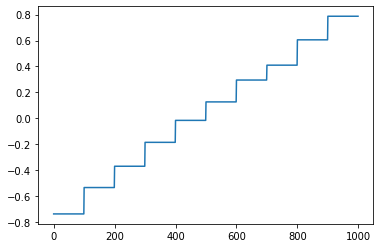

In [4]:
plt.plot(np.arange(1000),
         [f.get_value(i) for i in np.arange(1000)]
        )

In [14]:
# TD(0) Stochastic Gradient Descent
class TD0SGD():
    def __init__(self, func):
        self.func = func
        
    def episode(self, env):
        s,r,t = env.init()
        while True:
            s_,r,t = env.step()            
            self.func.update(s, r, s_)
            if t:
                break
            s = s_


# n-step TD
class TDnSGD():
    def __init__(self, func, n_step):
        self.func = func
        self.n_step = n_step
        
    def episode(self, env):
        
        s,r,t = env.init()
        history = [(s,r)]
        
        while True:
            s,r,t = env.step()  
            history.append((s,r))
            if len(history) == self.n_step:
                self.func.update(history)
            if t:
                while len(history) > 1:
                    self.func.update(history)
                break

In [15]:
# Linear approximation for n-step TD
class LinearApprox():
    def __init__(self, weights, alpha, gamma):
        self.weights = weights
        self.bias = np.ones_like(weights)
        self.alpha = alpha
        self.gamma = gamma
    
    def _get_state(self, state):
        return np.round((state - 500) / 100)
    
    def get_value(self, state):
        return np.dot(self._get_state(state), self.weights) + self.bias #state @ self.weights

    def update(self, history):
        
        state, reward = history.pop(0)
        expectation = self.get_value(state)
        
        discounts = np.cumsum(np.repeat(self.gamma, len(history)))
        returns = [discount*(elem[1]+self.get_value(elem[0])) 
                   for elem, discount in zip(history, discounts)]
        returns = reward + sum(returns)
        
        error = returns - expectation
        
        self.weights += self.alpha * error * self._get_state(state)
        self.bias += self.alpha * error

In [24]:
env = RandomWalk()
f = LinearApprox(np.array(-0.5), alpha=0.1, gamma=0.99)
estimator = TDnSGD(f, 2)
print(f"Weights: {f.weights}, Bias: {f.bias}")
for _ in range(1000):
    estimator.episode(env)
    f.alpha *= 0.95
print(f"Weights: {f.weights}, Bias: {f.bias}")

Weights: -0.5, Bias: 1.0
Weights: 0.31854068784644995, Bias: 0.42244724751474966


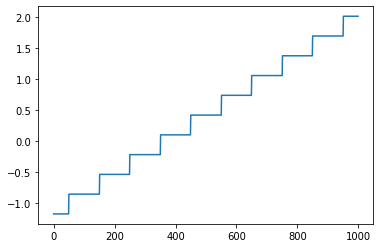

In [28]:
plt.plot(np.arange(1000),
         [f.get_value(i) for i in np.arange(1000)]
        )